# Neural Flow Diffusion Models from Scratch

## Imports and utilities

In [1]:
from abc import ABC, abstractmethod
from typing import Callable

import numpy as np


import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from Distributions2 import samplestudentT_4V2  as samplestudentT_4
from Distributions2 import  sample_funnel
from extreme_transforms_diffusion import TailAffineMarginalTransform_SeparateNetParam2
from scaler_grad_diffusion import NativeScalerWithGradNormCount as NativeScaler
import torch.nn.functional as F

In [2]:
approach='G' #A,G,C
Christ=False
upgrade=False
preprocess_base=True
faster=True
torch.manual_seed(42)
seed=42

In [3]:
def preprocess_inp_grigo(x,dim,device,inverse=False):
        NOISE2DATA=TailAffineMarginalTransform_SeparateNetParam2(dimz=dim).to(device)
        tail_params=torch.zeros(x.shape[0],4,dim)
        dummy_tail_param=tail_params.reshape(tail_params.shape[0],4,dim)
        _unc_pos_tail,_unc_neg_tail,_unc_shift,_unc_scale, = dummy_tail_param[:,0,:],dummy_tail_param[:,1,:],dummy_tail_param[:,2,:],dummy_tail_param[:,3,:]

        pos_tail_dummy=neg_tail_dummy=0.00333333+(0*torch.exp(_unc_pos_tail*0))#*0+0.0001

        shift=_unc_shift*0
        scale=(_unc_scale*0)+1

        valuez=torch.cat([pos_tail_dummy,neg_tail_dummy,shift,scale],1).to(device)
        if inverse:
            return NOISE2DATA.inverse(x,valuez)
        else:
            return NOISE2DATA(x,valuez)




In [4]:
# noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=1)
# xp=torch.randn(1,1,requires_grad=True)
# tailz=torch.abs(torch.randn(1,4))

# print(xp.shape,tailz.shape,xp)

# op=noise2data.inverse(xp,tailz)
# # print(op.shape)
# op.sum().backward()
# auto_grad = xp.grad

In [5]:
# auto_grad

In [6]:
# noise2data.fwd_dTTFInverse_dz(xp,tailz)
# print(op)

In [7]:
# auto_grad

In [8]:

# approach='A' #G- Grigory A-Mine

In [9]:
from network import MLP_diffusion, MLP_TailParam2
class Net(nn.Module):  #CAN USE IT FOR THE TAILNET aswell 
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, out_dim),
        )
        
    def forward(self, t: Tensor) -> Tensor:
        return self.net(t)



In [10]:
@torch.no_grad()
def solve_sde(
        sde: Callable[[Tensor, Tensor], tuple[Tensor, Tensor]],
        z: Tensor,
        ts: float,
        tf: float,
        n_steps: int,
        show_pbar: bool=False
):
    bs = z.shape[0]

    t_steps = torch.linspace(ts, tf, n_steps + 1).to(z.device)
    dt = (tf - ts) / n_steps
    dt_2 = (abs(dt) ** 0.5)

    path = [z]
    # print("PATH",z)
    pbar = tqdm if show_pbar else (lambda a: a)
    for t in pbar(t_steps[:-1]):
        t = t.expand(bs, 1).to(z.device)

        f, g = sde(z, t)

        w = torch.randn_like(z).to(z.device)
        z = z + f * dt + g * w * dt_2

        path.append(z)

    return z, (t_steps, torch.stack(path))


def solve_ode(
        ode: Callable[[Tensor, Tensor], Tensor],
        z: Tensor,
        ts: float,
        tf: float,
        n_steps: int,
        show_pbar: bool=False
):
    def sde(z_in: Tensor, t_in: Tensor) -> tuple[Tensor, Tensor]:
        return ode(z_in, t_in), torch.zeros_like(z_in)

    return solve_sde(sde, z, ts, tf, n_steps, show_pbar)

In [11]:
from typing import Optional
def viz_1d_path(t_steps: Tensor, path: Tensor, color: Optional[str] = None):
    plt.plot(t_steps, path, color=color, alpha=0.5)
    plt.show()

In [12]:
def viz_2d_data(data: Tensor):
    plt.scatter(data[:, 0], data[:, 1], s=1)
    plt.axis("scaled")
    plt.xlim(-80,80)
    plt.ylim(-80,80)
    plt.show()

In [13]:

def viz_2d_path(t_steps: Tensor, path: Tensor, n_lines: int = -1, color: Optional[str] = None):
    plt.figure(figsize=(12, 12))
    plt.scatter(15 + path[0, :, 0], path[0, :, 1], s=1)
    plt.scatter(path[-1, :, 0], path[-1, :, 1], s=1)
    plt.plot(15 * t_steps[:, None] + path[:, :n_lines, 0],
             path[:, :n_lines, 1],
             color=color, alpha=0.5)
    plt.axis("scaled")
    plt.tick_params(left=False, labelleft=False,
                    bottom=False, labelbottom=False)
    plt.show()

In [14]:
def train_test_split(data, test_ratio=0.5, seed=None):

    if seed is not None:
        np.random.seed(seed)
    
    B = data.shape[0]
    indices = np.random.permutation(B)
    test_size = int(B * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return data[train_indices], data[test_indices]


In [15]:
# def gen_data(n: int):
#     scale = 4.
#     centers = torch.tensor([
#         [1, 0],
#         [-1, 0],
#         [0, 1],
#         [0, -1],
#         [1. / np.sqrt(2), 1. / np.sqrt(2)],
#         [1. / np.sqrt(2), -1. / np.sqrt(2)],
#         [-1. / np.sqrt(2), 1. / np.sqrt(2)],
#         [-1. / np.sqrt(2), -1. / np.sqrt(2)]
#     ], dtype=torch.float32)
#     centers = scale * centers

#     x = torch.randn(n, 2)
#     x = 0.5 * x

#     center_ids = torch.randint(0, 8, (n,))
#     x = x + centers[center_ids]

#     x = x / 2 ** 0.5


#     return x

dof=1
x,_=samplestudentT_4(50,dof,1111111) 
ST_MEAN=x.mean(0).unsqueeze(0)
ST_STD=x.std(0).unsqueeze(0)/10

# St_data=(x-ST_MEAN)/(ST_STD+1e-6)
# St_data=preprocess_inp_grigo(St_data,2,'cpu',inverse=True)
# St_data_train,St_data_test=train_test_split(St_data,seed=seed)


# funnel_data=sample_funnel(20000)
# funnel_data=torch.tensor(funnel_data)
# funnel_data_train,funnel_data_test=train_test_split(funnel_data,seed=seed)


def gen_data(n:int):
    x,_=samplestudentT_4(50,dof,n) 
    x=torch.tensor(x)
    x=(x-ST_MEAN)/(ST_STD+1e-6)
    if preprocess_base:
        # print('hello')
        x=preprocess_inp_grigo(x,2,'cpu',inverse=True)

    return(x)

# def gen_data(n):
#     batch_size = n

#     # Generate random indices
#     Zdata_train=St_data_train
#     indices = torch.randperm(Zdata_train.shape[0])[:batch_size]

#     # Sample random batch
#     batch = Zdata_train[indices]
#     return(batch)

In [16]:
x.abs().max()

tensor(772932.3750)

## Forward Process

Here, we define the forward process through the reparameterization function $F_\varphi(\varepsilon, t, \mathbf{x})$. Although the NFDM framework allows for more general parameterizations, for simplicity, we use a Gaussian parameterization of $F_\varphi$ in this notebook:

\begin{align}
    \mathbf{z}_t = F_\varphi(\varepsilon, t, \mathbf{x}) = \mu_\varphi(\mathbf{x}, t) + \sigma_\varphi(\mathbf{x}, t) \varepsilon.
\end{align}

As a special case, we can parameterize it as a conditional optimal transport (FM-OT) flow:

\begin{align}
    \mathbf{z}_t = F(\varepsilon, t, \mathbf{x}) = \underbrace{(1 - t) \mathbf{x}}_{\mu(\mathbf{x}, t)} + \underbrace{(t + (1 - t) * 0.01)}_{\sigma(\mathbf{x}, t)} \varepsilon.
\end{align}

However, we will use a learnable Gaussian forward process (NFDM-Gaussian) in this notebook, where $\mu_\varphi$ and $\sigma_\varphi$ are parameterised by a neural network.

In [17]:
class AffineFlow(nn.Module, ABC):
    @abstractmethod
    def forward(self, x: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        raise NotImplementedError


class AffineOT(AffineFlow):
    def forward(self, x: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        return (1 - t) * x, t + (1 - t) * 0.01


class AffineNeural(AffineFlow):
    def __init__(self, d: int):
        super().__init__()

        # self.net = Net(d + 1, 2 * d)
        hidden_dim=128
        self.net=MLP_diffusion(input_dim=d, time_dim=1, hidden_dim=hidden_dim,output_dims=d*2)

    def forward(self, x: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        x_t = torch.cat([x, t], dim=1)
        m_ls = self.net(x_t)
        m, ls = m_ls.chunk(2, dim=1)

        m = (1 - t) * x + t * (1 - t) * m
        ls = (1 - t) * np.log(0.01) + t * (1 - t) * ls


        return m, torch.clamp(torch.exp(ls),-1000,1000)#aditya changed this
    
import torch.nn.functional as F
class TTFtailnet(AffineFlow):
    def __init__(self, d: int):
        super().__init__()

        # self.net = Net(d + 1, 2 * d)
        # self.tailnet=Net(1, 4 * d)
        hidden_dim=512#256 #256 for cones and studentT
        self.tailnet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*d)
        self.dim=d
        self.sp = nn.Softplus()
    def forward(self, t,extra=0):

        tail_params=self.tailnet(t)

        dummy_tail_param=tail_params.reshape(tail_params.shape[0],4,self.dim)
        _unc_pos_tail,_unc_neg_tail,_unc_shift,_unc_scale, = dummy_tail_param[:,0,:],dummy_tail_param[:,1,:],dummy_tail_param[:,2,:],dummy_tail_param[:,3,:]
        # pos_tail=torch.exp(_unc_pos_tail)/2
        # pos_tail=torch.exp((1 - t) * np.log(0.01) + t * (1 - t) * _unc_pos_tail)/3#*0+0.0001
        pos_tail_dummy=neg_tail_dummy=0.00333333+(0*torch.exp(_unc_pos_tail*0))#*0+0.0001
        # pos_tail=torch.sigmoid(_unc_pos_tail)/100
        # neg_tail=torch.sigmoid(_unc_neg_tail)/100
        if Christ and approach=='G':
            pos_tail=self.sp((1 - t) * np.log(0.01) + t * _unc_pos_tail)/3
            neg_tail=self.sp((1 - t) * np.log(0.01) + t * _unc_neg_tail)/3

            shift=_unc_shift#_unc_shift*0
            scale=self.sp(_unc_scale)+1e-6#(_unc_scale*0)+1

        else:
            pos_tail=torch.exp((1 - t) * np.log(0.1) + t * _unc_pos_tail)/3#*0+0.0001

            # neg_tail=torch.exp(_unc_neg_tail)/2 
             # neg_tail=torch.exp((1 - t) * np.log(0.01) + t * (1 - t) * _unc_neg_tail)/3#*0+0.0001
            neg_tail=torch.exp((1 - t) * np.log(0.1) + t * _unc_neg_tail)/3#*0+0.0001

            shift=_unc_shift*0#_unc_shift*0
            scale=self.sp(_unc_scale)*0+1#(_unc_scale*0)+1




        if extra==0:
            valuez=torch.cat([pos_tail,neg_tail,shift,scale],1)
        else:
            valuez=torch.cat([pos_tail_dummy,neg_tail_dummy,shift,scale],1)
            # print("snake")
            
        
        return valuez


In [18]:
torch.exp(torch.tensor(np.log(0.01)))/3

tensor(0.0033, dtype=torch.float64)

After defining $F_\varphi$, we can compute its corresponding conditional Ordinary Differential Equation (ODE), $f_\varphi(\mathbf{z}, t, \mathbf{x})$, as well as the conditional score function $\nabla_\mathbf{z_t} \log q_\varphi(\mathbf{z}_t, \mathbf{x})$, which is used in the conditional Stochastic Differential Equation (SDE).

\begin{align}
    \frac{d}{dt} f_\varphi(\mathbf{z}_t, t, \mathbf{x})
    &= \left. \frac{\partial F_\varphi(\varepsilon, t, \mathbf{x})}{\partial t} \right|_{\varepsilon=F_\varphi^{-1}(\mathbf{z}_t, t, \mathbf{x})} \\
    &= \left. \frac{\partial \mu_\varphi(\mathbf{x}, t)}{\partial t} + \frac{\partial \sigma_\varphi(\mathbf{x}, t)}{\partial t} \varepsilon \right|_{\varepsilon=F_\varphi^{-1}(\mathbf{z}_t, t, \mathbf{x})} \\
    &= \frac{\partial \mu_\varphi(\mathbf{x}, t)}{\partial t} + \frac{\partial \sigma_\varphi(\mathbf{x}, t)}{\partial t} \frac{\mathbf{z} - \mu_\varphi(\mathbf{x}, t)}{\sigma_\varphi(\mathbf{x}, t)}
\end{align}

\begin{align}
    \nabla_\mathbf{z_t} \log q_\varphi(\mathbf{z}_t, \mathbf{x})
    &= \left. - \frac{\varepsilon}{\sigma_\varphi(\mathbf{x}, t)} \right|_{\varepsilon=F_\varphi^{-1}(\mathbf{z}_t, t, \mathbf{x})} \\
    &= \frac{\mu_\varphi(\mathbf{x}, t) - \mathbf{z}}{\sigma^2_\varphi(\mathbf{x}, t)}
\end{align}



In [19]:
from typing import Callable, Tuple
import torch
from torch import Tensor

def jvp(f: Callable[[Tensor], Tuple[Tensor, ...]], x: Tensor, v: Tensor) -> Tuple[Tensor, ...]:
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )

def t_dir(f: Callable[[Tensor], Tuple[Tensor, ...]], t: Tensor) -> Tuple[Tensor, ...]:
    return jvp(f, t, torch.ones_like(t))



class AffineTransform(nn.Module):
    def __init__(self, flow: AffineFlow):
        super().__init__()

        self.flow = flow

    def get_t_dir(self, x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
        def f(x_in):
            def f_(t_in):
                return self.flow(x_in, t_in)
            return f_

        return t_dir(f(x), t)

    def forward(self, eps: Tensor, t: Tensor, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        (m, s), (dm, ds) = self.get_t_dir(x, t)

        z = m + s * eps
        dz = dm + ds * eps
        score = - eps / s

        return z, dz, score,z

    def inverse(self, z: Tensor, t: Tensor, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        (m, s), (dm, ds) = self.get_t_dir(x, t)

        eps = (z - m) / s
        dz = dm + ds / s * (z - m)
        score = (m - z) / s ** 2

        return eps, dz, score

In [20]:
from typing import Callable, Tuple
import torch
from torch import Tensor

# def jvp_TTF(f: Callable[[Tensor], Tuple[Tensor, ...]], x: Tensor, v: Tensor) -> Tuple[Tensor, ...]:
#     return torch.autograd.functional.jvp(
#         f, x, v, 
#         create_graph=torch.is_grad_enabled()
#     )

# def t_dir_TTF(f: Callable[[Tensor], Tuple[Tensor, ...]], t: Tensor) -> Tuple[Tensor, ...]:
#     return jvp(f, t, torch.ones_like(t))



class AffineTransform_TTF(nn.Module):
    def __init__(self,dim,noise2data, tail: AffineFlow,linearflow:AffineFlow):
        super().__init__()

        self.tail = tail
        self.noise2data=noise2data
        self.dim=dim
        self.linearflow=linearflow

    def get_t_dir_tail(self,x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:  #dG/dT
        def flow(Xz,timez):
            # print("XZ_t",Xz.shape,timez.shape)
            param_tail=self.tail(timez)


            return(param_tail)
        

        def f(x_in):
                def f_(t_in):
                    return flow(x_in, t_in)
                return f_

        return t_dir(f(x), t)




    def get_t_dir_TTFinvfaster(self,XX,TTail_param):
        TTail_param2=TTail_param.reshape(TTail_param.shape[0],4,self.dim)

        _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2 = TTail_param2[:,0,:],TTail_param2[:,1,:],TTail_param2[:,2,:],TTail_param2[:,3,:]
        s = torch.sign(XX - shift2)
        lambda_s = torch.where(s > 0, _unc_pos_tail2, _unc_neg_tail2)
        y = lambda_s * torch.abs((XX - shift2) / _unc_scale2) + 1
        sub=s * (1 + lambda_s)/(_unc_scale2*y)



        total=self.noise2data.inverse(XX,TTail_param)*self.noise2data.fwd_dTTFInverse_dz(XX,TTail_param)-sub
        return(total)



    def get_t_dir_TTFinf(self,loc,X: Tensor, TTail_param: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
        def flow(Xz,tail_param):
            # print("XZ_t",Xz.shape,timez.shape)
            olddim=self.noise2data.dimz
            oldog_tail_shape=self.noise2data.og_tail_shape
            self.noise2data.dimz=1
            self.noise2data.og_tail_shape=(4,1)
            param_tail_eps=tail_param
            dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,self.dim)
            _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,loc],dummy_tail_param2[:,1,loc],dummy_tail_param2[:,2,loc],dummy_tail_param2[:,3,loc]

            D1= (_unc_pos_tail2).unsqueeze(1)
            D2= (_unc_neg_tail2).unsqueeze(1)
            D3=shift2.unsqueeze(1)
            D4= (_unc_scale2).unsqueeze(1) 

            tail_param=torch.cat([D1,D2,D3,D4],1)
            
            x_inp=Xz[:,loc].unsqueeze(1)
            # print("impTail_param",tail_param.shape,x_inp.shape)
            
            valuez=torch.log(0.00001+torch.abs(self.noise2data.fwd_dTTFInverse_dz(x_inp,tail_param)))
            has_nan = torch.isnan(valuez).any()
            if has_nan:
                print('valuez has nan')
                print(ora)

                # print("valuez")
            self.noise2data.dimz=olddim
            self.noise2data.og_tail_shape=oldog_tail_shape
            return(valuez)
        def f(t):
                def f_(x_in):
                    return flow(x_in, t)
                return f_

        return t_dir(f(TTail_param), X)    
    
    def get_t_dir(self, x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
        def f(x_in):
            def f_(t_in):
                return self.linearflow(x_in, t_in)
            return f_

        return t_dir(f(x), t)
    

    def forward(self, eps: Tensor, t: Tensor, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        dim=self.dim


        tail_param,True_timederiv=self.get_t_dir_tail(x,t) # dG/dt  
        if upgrade:
            tail_param2=self.tail(t*0+1,1)
            x=self.noise2data.inverse(x,tail_param2.detach()) #upgrade


        
        (m, s), (dm, ds) = self.get_t_dir(x, t)  #dmu/dt ,dsigma/dt
        
        param_grad=True_timederiv  

        z = m + s * eps   #prefinal 
        
        has_nan = torch.isnan(z).any()
        if has_nan:
            print('inverse z look has nan',m.mean(),s.mean(),eps.mean())
            print(or2a) 

        z_final=self.noise2data(z,tail_param) #final
                    
        B=z
        A=tail_param
            # print("phi_t",phi_t.shape,param_tail.shape) #BATCH X 2
            # print(a)

            

        jacobian_phi=self.noise2data.fwd_dTTF_dz(B, A) #B X 20 X 20 dR/dB
        #     # print("jac_phi",jacobian_phi.shape)
        jacobian_param_tail=(self.noise2data.dTTF_dtailparam(B, A)) #list of 4  ,BX20 dR/dA

        dz = dm + ds * eps #dF/dt da_t/dt
        prefinal_vf=dz

        first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
        second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2) #dR/dB x dB/dt
        dz_final=first_part+second_part #dR/dT



        score = - eps / s
        score_final_1=score*self.noise2data.fwd_dTTFInverse_dz(z_final,tail_param)
        # print("fwd,score_final_1",score_final_1.shape)
        emp=[]
        if faster:
            score_final_2=self.get_t_dir_TTFinvfaster(z_final,tail_param)
        else:
            for i in range(self.dim):
                emp.append(self.get_t_dir_TTFinf(i,z_final,tail_param)[1])
            score_final_2=torch.cat(emp,1)
        score_final=score_final_1+score_final_2
        # print("hola2",score_final_1.mean(),score_final_2.mean())

        return z_final, dz_final, score_final,z

    def inverse(self, z_final: Tensor, t: Tensor, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:  #check

        tail_param,True_timederiv=self.get_t_dir_tail(x,t) # dG/dt 

        if upgrade:
            tail_param2=self.tail(t*0+1,1)
            x=self.noise2data.inverse(x,tail_param2.detach()) #upgrade

        (m, s), (dm, ds) = self.get_t_dir(x, t) 
        # print("HELLO",m.shape,s.shape,dm.shape,ds.shape)# BATCH X DIM all
 
        # print("hello2",tail_param.shape,True_timederiv.shape) #BATCH X 4DIM all
        z=self.noise2data.inverse(z_final,tail_param) # BATCH X DIM  UNREMARK
        # print("z",z.shape) 




        has_nan = torch.isnan(z).any()
        if has_nan:
            print('inverse z has nan')
            print(or2a) 

        has_nan = torch.isnan(dm).any()
        if has_nan:
            print('inverse dm has nan')
            print(or2oa) 

        has_nan = torch.isnan(ds).any()
        if has_nan:
            print('inverse ds has nan')
            print(or2oa) 

        has_nan = torch.isnan(m).any()
        if has_nan:
            print('inverse m has nan')
            print(or2zoa) 

        eps = (z - m) / s

        has_nan = torch.isnan(eps).any()
        if has_nan:
            print('inverse eps has nan',torch.sum(s==0))
            print(or2zoa) 


        dz = dm + ds *eps # BATCH X DIM 
        has_nan = torch.isnan(dz).any()
        if has_nan:
            print('inverse dz has nan',dm.mean(),ds.mean(),eps.mean())
            print(or2zoa) 

        
        # print('dz',dz.shape)

        B=z
        A=tail_param
        jacobian_phi=self.noise2data.fwd_dTTF_dz(B, A) #B X dim X dim dR/dB
        # print("jac_phi",jacobian_phi.shape)
        jacobian_param_tail=(self.noise2data.dTTF_dtailparam(B, A)) #list of 4  ,BXdim dR/dA
        # print("jacobian_param_tail",jacobian_param_tail[0].shape)

        prefinal_vf=dz
        param_grad=True_timederiv 
        dim=self.dim
        first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
        second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)

        has_nan = torch.isnan(jacobian_phi).any()
        if has_nan:
            print('jacobian_phi has nan')
            print(ora) 

        
        has_nan = torch.isnan(prefinal_vf).any()
        if has_nan:
            print('prefinal_vf has nan')
            print(ora) 
        
        # print("parts",first_part.shape,second_part.shape) #Batch x dim
        dz_final=first_part+second_part #dR/dT



        score = - eps / s #BxDim
        # print("score",score.shape,self.noise2data.fwd_dTTFInverse_dz(z_final,tail_param).shape,)
        score_final_1=score*self.noise2data.fwd_dTTFInverse_dz(z_final,tail_param)  #batch x dim
        # print("score_final1",score_final_1.shape)
        if faster:
            score_final_2=self.get_t_dir_TTFinvfaster(z_final,tail_param)
        else:
            emp=[]
            for i in range(self.dim):
                emp.append(self.get_t_dir_TTFinf(i,z_final,tail_param)[1])
            score_final_2=torch.cat(emp,1)
        score_final=score_final_1+score_final_2
        # print("hola",score_final_1.mean(),score_final_2.max())



        return eps, dz_final, score_final

In [21]:
flow= AffineNeural(d=1)
tail_net=TTFtailnet(d=1)
tailP=tail_net(torch.zeros(5,1))
xp=torch.randn(5,1)

noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=1)
transform=AffineTransform_TTF(1,noise2data,tail_net,flow)

In [22]:
# u=torch.randn(2,2)+1
# r=torch.abs(torch.randn(2,8))

In [23]:
# transform.get_t_dir_TTFinf(1,u,r)

In [24]:
# transform.get_t_dir_TTFinvfaster(u,r)

C:\Users\adity\AppData\Local\Temp\ipykernel_11556\1627872237.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x)


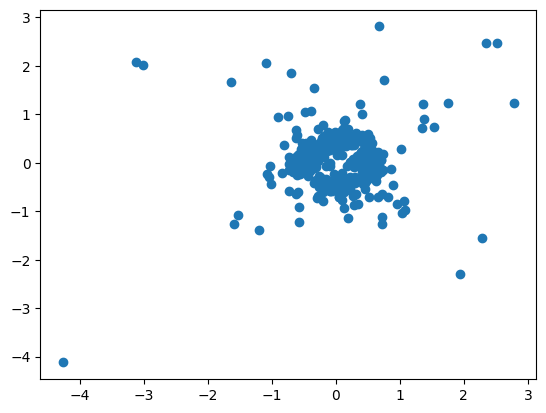

In [25]:
flow= AffineNeural(d=2)
tail_net=TTFtailnet(d=2)
tailP=tail_net(torch.zeros(5000,1)+0)
tailP[:,0:4]=tailP[:,0:4]*1
tailP2=tail_net(torch.zeros(5000,1)+1)
noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=2)
xp=gen_data(5000)
op=noise2data(xp,tailP).cpu().detach()

plt.scatter(xp[:,0],xp[:,1],label='xp')
# plt.scatter(op[:,0],op[:,1],label='op')
# z=0.2
# plt.xlim(-0.3*z,0.3*z)
# plt.ylim(-0.3*z,0.3*z)

In [26]:
tailP[:,0:4]

tensor([[0.0333, 0.0333, 0.0333, 0.0333],
        [0.0333, 0.0333, 0.0333, 0.0333],
        [0.0333, 0.0333, 0.0333, 0.0333],
        ...,
        [0.0333, 0.0333, 0.0333, 0.0333],
        [0.0333, 0.0333, 0.0333, 0.0333],
        [0.0333, 0.0333, 0.0333, 0.0333]], grad_fn=<SliceBackward0>)

In [27]:
tailP[0]

tensor([0.0333, 0.0333, 0.0333, 0.0333, 0.0000, -0.0000, 1.0000, 1.0000],
       grad_fn=<SelectBackward0>)

In [28]:
tailP2[0]

tensor([0.3060, 0.3824, 0.3974, 0.2960, 0.0000, -0.0000, 1.0000, 1.0000],
       grad_fn=<SelectBackward0>)

In [29]:
tailP[0]

tensor([0.0333, 0.0333, 0.0333, 0.0333, 0.0000, -0.0000, 1.0000, 1.0000],
       grad_fn=<SelectBackward0>)

In [30]:
noise2data.fwd_dTTFInverse_dz(noise2data.forward(xp,tailP),tailP)

tensor([[1.1449, 0.9441],
        [1.2148, 0.9063],
        [1.2100, 0.9035],
        ...,
        [0.8521, 1.2452],
        [0.8770, 1.2442],
        [0.7892, 1.2305]], grad_fn=<ClampBackward1>)

As a simple example, we can visualize the path of the forward process in 1D. Importantly, in this example, the forward process is not trained. Nevertheless, thanks to the parameterization, we can observe that the trajectories start near $\mathbf{x}=-1$ and end at their corresponding $\varepsilon$ values.

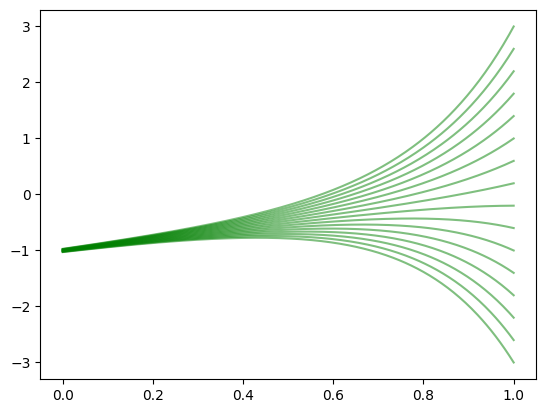

In [31]:
bs = 16
device='cuda:0'
x = -torch.ones(bs, 1).to(device)
z = torch.linspace(-3, 3, bs)[:, None].to(device)

if approach=='G':
    flow = AffineNeural(d=1) 
    transform = AffineTransform(flow=flow).to(device)
else:
    flow= AffineNeural(d=1)
    tail_net=TTFtailnet(d=1)
    noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=1).to(device)
    transform=AffineTransform_TTF(1,noise2data,tail_net,flow).to(device)
    


def cond_ode(z_in, t_in):
    z_in=z_in.to(device)
    t_in=t_in.to(device)
    _, dz, _ = transform.inverse(z_in, t_in, x)
    return dz


_, (t_steps, path) = solve_ode(ode=cond_ode, z=z, ts=1, tf=0, n_steps=300)

# tailp=tail_net(x*0)
# path[300,:,0]=noise2data.inverse(path[300,:,0].unsqueeze(1),tailp).squeeze(1).detach()
path=path.cpu()
t_steps=t_steps.cpu()

viz_1d_path(t_steps, path[:, :, 0], color="green")

Next, we introduce the volatility function $g_\varphi(t)$, which parameterizes the volatility of the conditional SDE. Similar to the function $F_\varphi$, the volatility can be either fixed or parameterized by a neural network.

With access to the conditional ODE, the conditional score function, and the volatility, we can compute the drift term of the conditional SDE:

\begin{align}
    d \mathbf{z}_t &= \tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x}) d t + g_\varphi(t) d \bar{w}, \quad \textrm{where} \\
    \tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x}) &= f_\varphi(\mathbf{z}_t, t, \mathbf{x}) - \frac{g_\varphi^2(t)}{2} \nabla_\mathbf{z_t} \log q(\mathbf{z}_t, \mathbf{x}).
\end{align}

In [32]:
class VolatilityLinSNR(nn.Module):
    def forward(self, t: Tensor) -> Tensor:
        return (20 * torch.sigmoid(-10 + 20 * t)) ** 0.5


class VolatilityNeural(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = Net(1, 1)
        self.sp = nn.Softplus()

    def forward(self, t: Tensor) -> Tensor:
        return self.sp(self.net(t))

In [33]:
def score_based_sde_drift(dz: Tensor, score: Tensor, g2: Tensor) -> Tensor:
    return dz - 0.5 * g2 * score

In [34]:
torch.cosh(torch.tensor(48))

tensor(3.5084e+20)

Similarly to the example with the conditional ODE, we can visualize the trajectories of the conditional SDE in 1D.

tensor(14.7724, device='cuda:0') tensor(3., device='cuda:0') tensor(3., device='cuda:0') tensor(-1., device='cuda:0')
tensor(14.2369, device='cuda:0') tensor(2.6691, device='cuda:0') tensor(2.8808, device='cuda:0') tensor(-1., device='cuda:0')
tensor(15.3926, device='cuda:0') tensor(2.7388, device='cuda:0') tensor(3.1281, device='cuda:0') tensor(-1., device='cuda:0')
tensor(15.0232, device='cuda:0') tensor(2.8820, device='cuda:0') tensor(3.0449, device='cuda:0') tensor(-1., device='cuda:0')
tensor(14.2956, device='cuda:0') tensor(3.0989, device='cuda:0') tensor(2.8840, device='cuda:0') tensor(-1., device='cuda:0')
tensor(13.4148, device='cuda:0') tensor(3.1648, device='cuda:0') tensor(2.6900, device='cuda:0') tensor(-1., device='cuda:0')
tensor(13.7014, device='cuda:0') tensor(3.2194, device='cuda:0') tensor(2.7489, device='cuda:0') tensor(-1., device='cuda:0')
tensor(14.0016, device='cuda:0') tensor(3.1764, device='cuda:0') tensor(2.8108, device='cuda:0') tensor(-1., device='cuda:0')


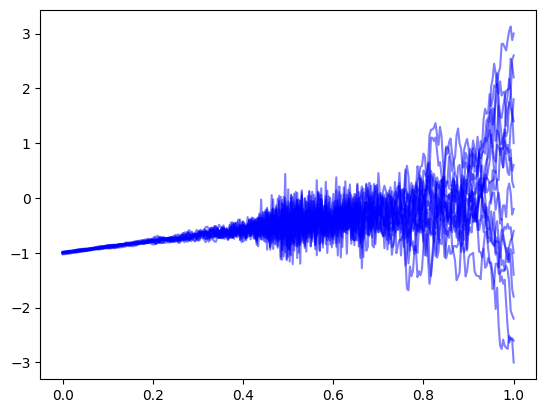

In [35]:
bs = 16

x = -torch.ones(bs, 1).to(device)
z = torch.linspace(-3, 3, bs)[:, None].to(device)

 

if approach=='G':
    flow = AffineNeural(d=1)
    transform = AffineTransform(flow=flow).to(device)
else:
    flow= AffineNeural(d=1)
    tail_net=TTFtailnet(d=1)
    noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=1).to(device)
    transform=AffineTransform_TTF(1,noise2data,tail_net,flow).to(device)
    







vol = VolatilityLinSNR().to(device)


def cond_sde(z_in, t_in):
    # print("z_",x)
    _, dz, score = transform.inverse(z_in, t_in, x)
    print(dz.max(),score.max(),z_in.max(),x.max())

    g = vol(t_in)
    g2 = g ** 2

    drift = score_based_sde_drift(dz, score, g2)

    return drift, g


_, (t_steps, path) = solve_sde(sde=cond_sde, z=z, ts=1, tf=0, n_steps=300)

path=path.cpu()
t_steps=t_steps.cpu()

viz_1d_path(t_steps, path[:, :, 0], color="blue")

In [36]:
path[300, :, 0]

tensor([-1.0068, -1.0281, -0.9878, -1.0082, -0.9843, -1.0096, -1.0026, -0.9892,
        -1.0140, -1.0031, -0.9870, -1.0001, -0.9957, -1.0004, -1.0006, -0.9780])

## Reverse (Generative) Process

The reverse (or generative) process is defined by the marginal SDE:
\begin{align}
    d \mathbf{z}_t &= \tilde{f}_\theta(\mathbf{z}_t, t) d t + g_\varphi(t) d \bar{w}.
\end{align}

The parameterization of the drift term $\tilde{f}_\theta(\mathbf{z}t, t)$ is a design choice. In this notebook, we parameterize it by predicting $\hat{\mathbf{x}}_\theta(\mathbf{z}t, t)$ and then substituting it into the conditional SDE $\tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x})$:

\begin{align}
    \tilde{f}_{\varphi, \theta}(\mathbf{z}_t, t) = \tilde{f}_\varphi \big( \mathbf{z}_t, t, \hat{\mathbf{x}}_\theta(\mathbf{z}_t, t) \big).
\end{align}

In [37]:
class Predictor(nn.Module):
    def __init__(self, d: int):
        super().__init__()

        self.net = Net(d + 1, d) #cones
        hidden_dim=128
        # self.net=MLP_diffusion(input_dim=d, time_dim=1, hidden_dim=hidden_dim,output_dims=d)
        self.tail_net=TTFtailnet(d)
        self.noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=d).to(device)
    def forward(self, z: Tensor, t: Tensor) -> Tensor:



        z_t = torch.cat([z, t], dim=1)
        x = self.net(z_t)




        if approach=='G' and Christ:
            # print("justice")
            tail=self.tail_net(t)
            x=self.noise2data(x,tail)
        
        

        x = (1 - t) * z + (t + 0.01) * x



        return x

## Neural Flow Diffusion Model

Finally, we can define the Neural Flow Diffusion Model (NFDM) that combines the forward and reverse processes. The loss function of the NFDM is the expectation of the squered norm of difference between the drift terms of the forward and reverse processes:

\begin{align}
    \mathcal{L}(\mathbf{x}, t) = \mathbb{E}_{u(t) q_\varphi(\mathbf{z}_t, \mathbf{x})} \left[ \frac{g_\varphi^2(t)}{2} \left\| \tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x}) - \tilde{f}_{\varphi, \theta}(\mathbf{z}_t, t) \right\|_2^2 \right].
\end{align}

In [38]:
class NeuralDiffusion(nn.Module):
    def __init__(self, transform: AffineTransform, pred: Predictor, vol: nn.Module):
        super().__init__()

        self.transform = transform
        self.pred = pred
        self.vol = vol

    def forward(self, x: Tensor, t: Tensor):
        eps = torch.randn_like(x)

        z, f_dz, f_score,z_pre = self.transform(eps, t, x)
        

        x_ = self.pred(z_pre, t)
        if upgrade:
            tail_param2=self.transform.tail(t*0+1,1)
            x_=self.transform.noise2data(x_,tail_param2.detach()) #upgrade
        _, r_dz, r_score = self.transform.inverse(z, t, x_)

        g2 = self.vol(t) ** 2
        f_drift = score_based_sde_drift(f_dz, f_score, g2)
        r_drift = score_based_sde_drift(r_dz, r_score, g2)
        # print("drifts,",f_drift.mean(),r_drift.mean())
        has_nan = torch.isnan(f_drift).any()
        if has_nan:
            print('f_drift has nan')
        has_nan = torch.isnan(r_drift).any()
        if has_nan:
            print('r_drift has nan')   
            has_nan2= torch.isnan(r_score).any()   
            if has_nan2:
                print('r_score has nan')
            has_nan2= torch.isnan(r_dz).any()   
            if has_nan2:
                print('r_dz has nan')            

        loss = 0.5 * (f_drift - r_drift) ** 2 / g2
        loss = loss.sum(dim=1)

        return loss

## Training

C:\Users\adity\AppData\Local\Temp\ipykernel_11556\1627872237.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x)


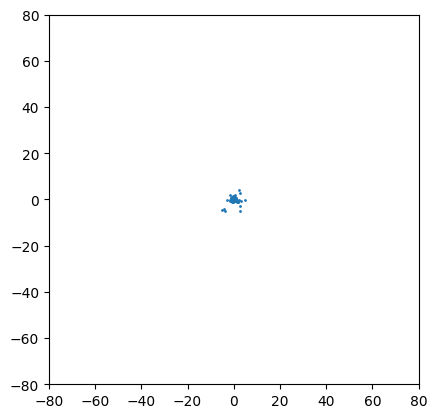

In [39]:
data_sample = gen_data(2 ** 12)


viz_2d_data(data_sample)


In [40]:
loss_scaler = NativeScaler()

c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\scaler_grad_diffusion.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [41]:
def train(model: NeuralDiffusion, gen_data_f: Callable[[int], Tensor],device='cuda:0'):
    iter = (10 ** 4)*5
    bs = (2 ** 10)*4
    # model=model.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)
    

    pbar = trange(iter)
    for i in pbar:
        optim.zero_grad()
        x = gen_data_f(bs).to(device)
        # print(x.shape,data_sample.mean(0).shape)
        # x=(x-data_sample.mean(0).unsqueeze(0))/data_sample.std(0).unsqueeze(0)
        t = torch.rand(x.shape[0], 1).to(device)
        # x=x.cuda()
        # t=t.cuda()
        loss = model(x, t).mean()

        if (i + 1) % 100 == 0:
            pbar.set_description(f"{loss.item():.4f}")
        
        # optim.zero_grad()
        # loss.backward()
        # optim.step()
        loss_scaler(
            loss,
            optim,
            parameters=model.parameters(),
            update_grad=True,
            )   

In [42]:
 
if approach=='G':
    flow = AffineNeural(d=2)
    transform = AffineTransform(flow=flow).to(device)
else:
    flow= AffineNeural(d=2)
    tail_net=TTFtailnet(d=2)
    noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=2).to(device)
    transform=AffineTransform_TTF(2,noise2data,tail_net,flow).to(device)
    

pred = Predictor(d=2)
vol = VolatilityNeural()
ndm = NeuralDiffusion(transform, pred, vol).to(device)

train(model=ndm, gen_data_f=gen_data)

  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\adity\AppData\Local\Temp\ipykernel_11556\1627872237.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x)
3.8989:  21%|██        | 10426/50000 [04:51<18:25, 35.79it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(transform.state_dict(), 'model_cone_ttfdiff0_5.pth')


In [ ]:
# ndm.transform.noise2data.og_tail_shape=(4,2)
# ndm.transform.noise2data.dimz=2

In [ ]:
approach,upgrade

('G', False)

## Visualization of the learned diffusion process

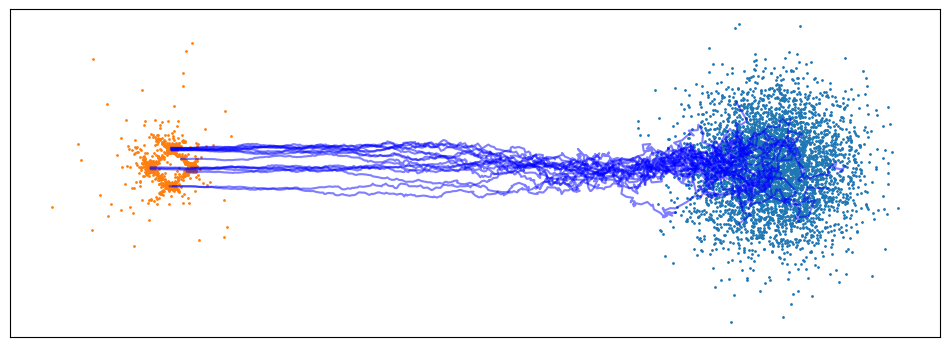

In [43]:
bs = 2 ** 12

zt = torch.randn(bs, 2).to(device)

if approach=='A':
    tailp=ndm.transform.tail(torch.ones(zt.shape[0],1).to(device))
    zt=ndm.transform.noise2data(zt,tailp)
else:
    zt = torch.randn(bs, 2).to(device)



def sde(z_in, t_in):
    z_middle=z_in
    if approach=='A':
        tailp=ndm.transform.tail(t_in).to(device)
        z_middle=ndm.transform.noise2data.inverse(z_in,tailp)


    x_ = pred(z_middle, t_in)
    if upgrade and approach=='A':
        tail_param2=ndm.transform.tail(t_in*0+1,1)
        x_=ndm.transform.noise2data(x_,tail_param2.detach()) #upgrade

    _, dz, score = ndm.transform.inverse(z_in, t_in, x_)

    g = vol(t_in)
    g2 = g ** 2

    drift = score_based_sde_drift(dz, score, g2)

    return drift, g


_, (t_steps, path) = solve_sde(sde=sde, z=zt, ts=1, tf=0, n_steps=300)

path=path.cpu()
t_steps=t_steps.cpu()
viz_2d_path(t_steps, path, n_lines=16, color="blue")

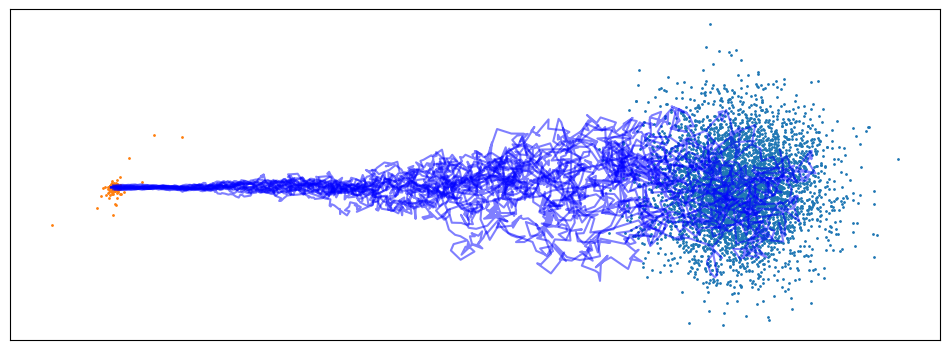

In [ ]:
bs = 2 ** 12

zt = torch.randn(bs, 2).to(device)

if approach=='A':
    tailp=ndm.transform.tail(torch.ones(zt.shape[0],1).to(device))
    zt=ndm.transform.noise2data(zt,tailp)
else:
    zt = torch.randn(bs, 2).to(device)



def sde(z_in, t_in):
    z_middle=z_in
    if approach=='A':
        tailp=ndm.transform.tail(t_in).to(device)
        z_middle=ndm.transform.noise2data.inverse(z_in,tailp)


    x_ = pred(z_middle, t_in)
    if upgrade and approach=='A':
        tail_param2=ndm.transform.tail(t_in*0+1,1)
        x_=ndm.transform.noise2data(x_,tail_param2.detach()) #upgrade

    _, dz, score = ndm.transform.inverse(z_in, t_in, x_)

    g = vol(t_in)
    g2 = g ** 2

    drift = score_based_sde_drift(dz, score, g2)

    return drift, g


_, (t_steps, path) = solve_sde(sde=sde, z=zt, ts=1, tf=0, n_steps=300)

path=path.cpu()
t_steps=t_steps.cpu()
viz_2d_path(t_steps, path, n_lines=16, color="blue")

In [ ]:
data_sample = gen_data(2 ** 12)
 

C:\Users\adity\AppData\Local\Temp\ipykernel_4320\1627872237.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x)


C:\Users\adity\AppData\Local\Temp\ipykernel_11556\3855985312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_sample_p=torch.tensor(data_sample)


(-1.5, 1.5)

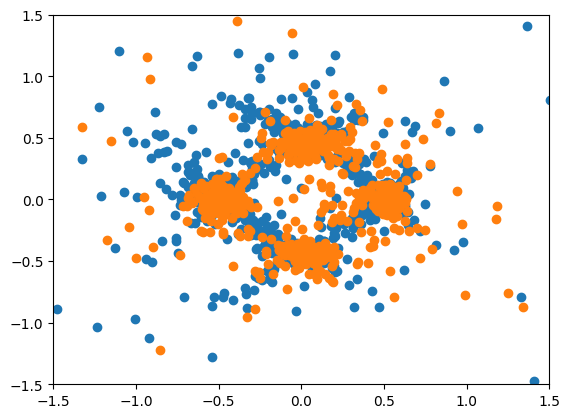

In [44]:
n_steps=300
data_sample_p=torch.tensor(data_sample)
if approach=='A':
    print(path[n_steps,:,0].shape)
    print(t_steps[n_steps])
    tailp=ndm.transform.tail((path[n_steps,:,0].cuda()*0+t_steps[n_steps]).unsqueeze(1).to(device))
    # print(tailp)
    # v=path[300,:,:]
    print("yes")
    v=ndm.transform.noise2data.inverse(torch.tensor(path[n_steps,:,:]).to(device),tailp).squeeze(0).detach()
    if upgrade:
        tail_param2=ndm.transform.tail(path[n_steps,:,0].unsqueeze(1).cuda()*0+1,1)
        v=ndm.transform.noise2data(v,tail_param2.detach()) #upgrade

    if preprocess_base:
        # data_sample=preprocess_inp_grigo(data_sample.cuda(),2,device)
        # v=preprocess_inp_grigo(v,2,device)
        print('yes2')
    
else:
    v=path[n_steps]
v=v.cpu()
# v= (v*ST_STD)+ST_MEAN
# z=z.cpu().detach()
plt.scatter(v[:,0],v[:,1])
zt=zt.cpu()
plt.scatter(data_sample[:,0].cpu(),data_sample[:,1].cpu())
# plt.xlim(-0.2,0.2)
# plt.ylim(-0.2,0.2)
z=5
plt.xlim(-0.3*z,0.3*z)
plt.ylim(-0.3*z,0.3*z)

In [ ]:
 
# if approach=='A':
#     print(path[n_steps,:,0].shape)
#     print(t_steps[n_steps])
#     tailp=ndm.transform.tail((path[n_steps,:,0].cuda()*0+t_steps[n_steps]).unsqueeze(1).to(device))
#     # print(tailp)
#     # v=path[300,:,:]
#     print("yes")
#     v=ndm.transform.noise2data.inverse(torch.tensor(path[n_steps,:,:]).to(device),tailp).squeeze(0).detach()
#     if upgrade:
#         tail_param2=ndm.transform.tail(path[n_steps,:,0].unsqueeze(1).cuda()*0+1,1)
#         v=ndm.transform.noise2data(v,tail_param2.detach()) #upgrade
# else:
#     v=path[n_steps]
# v=v.cpu()
# # v= (v*ST_STD)+ST_MEAN
# # z=z.cpu().detach()

# zt=zt.cpu()
# plt.scatter(v[:,0],v[:,1])
# plt.scatter(data_sample[:,0],data_sample[:,1])
 
# z=0.3
# plt.xlim(-0.3*z,0.3*z)
# plt.ylim(-0.3*z,0.3*z)

In [ ]:
# np.save('stundentT_vanilla_nopreprocess.npy',v)
# v=np.load("stundentT_vanilla_nopreprocess.npy")

In [ ]:
vanilla=torch.tensor(np.load("stundentT_vanilla_nopreprocess.npy"))

C:\Users\adity\AppData\Local\Temp\ipykernel_11556\3825461320.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v=torch.tensor(v)


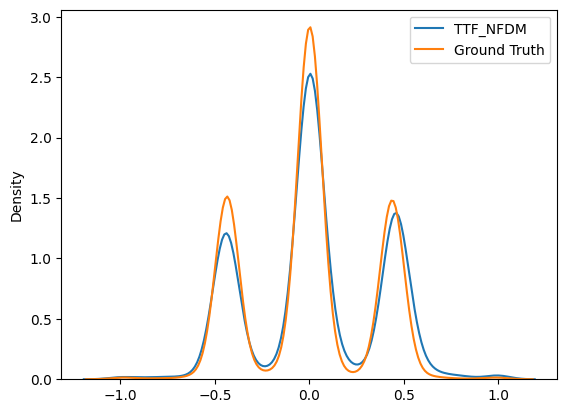

In [45]:
import seaborn as sns
v=torch.tensor(v)
lim=1
sns.kdeplot(torch.clamp(v[:,1],-1*lim,lim),label='TTF_NFDM')
sns.kdeplot(torch.clamp(data_sample[:,1].detach().cpu(),-1*lim,lim),label='Ground Truth')
# sns.kdeplot(torch.clamp(vanilla[:,1],-1*lim,lim),label='NFDM')
plt.legend()
plt.show()



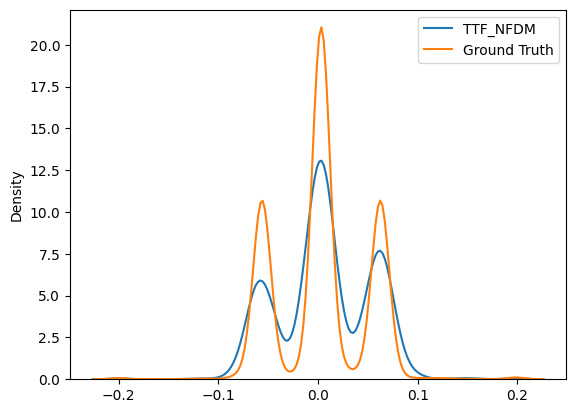

In [ ]:


sns.kdeplot(torch.clamp(v[:,0],-1*lim,lim),label='TTF_NFDM')
sns.kdeplot(torch.clamp(data_sample[:,0].detach().cpu(),-1*lim,lim),label='Ground Truth')
# sns.kdeplot(torch.clamp(vanilla[:,0],-1*lim,lim),label='NFDM')
plt.legend()
plt.show()



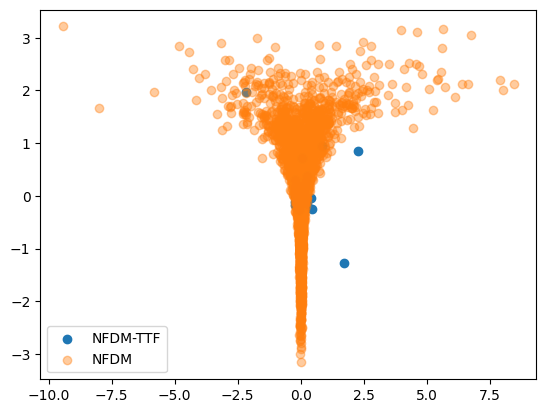

In [ ]:
plt.scatter(v[:,0],v[:,1],label='NFDM-TTF')
plt.scatter(vanilla[:,0],vanilla[:,1],alpha=0.4,label='NFDM')
plt.legend()
plt.show()
# plt.scatter(data_sample[:,0],data_sample[:,1],alpha=0.1)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

def plot_wasserstein_distances(generate_data: np.ndarray, test_data: np.ndarray):
    """
    Computes and plots Wasserstein distances for each feature between generated and test data.

    Parameters:
    - generate_data: np.ndarray of shape (N, D)
    - test_data: np.ndarray of shape (N, D)
    """
    assert generate_data.shape[1] == test_data.shape[1], "Feature dimensions must match"
    num_features = generate_data.shape[1]
    
    distances = [
        wasserstein_distance(test_data[:, i], generate_data[:, i])
        for i in range(num_features)
    ]
    
    return distances  # Optional: return the distances for further use


In [ ]:
import torch
from scipy import stats

def compute_kurtosis_ratio(
    generated_data: torch.Tensor, 
    test_data: torch.Tensor,
    eps: float = 1e-8
) -> torch.Tensor:
 
    generated_np = generated_data.flatten().cpu().numpy()
    test_data_np = test_data.flatten().cpu().numpy()

 
    k_sim = stats.kurtosis(generated_np, fisher=True, bias=True)
    k_data = stats.kurtosis(test_data_np, fisher=True, bias=True)

    kr = abs(1 - (k_sim / (k_data + eps)))
    
 
    return torch.tensor(kr, dtype=torch.float32)

def compute_skewness_ratio(
    generated_data: torch.Tensor, 
    test_data: torch.Tensor,
    eps: float = 1e-8
) -> torch.Tensor:
 
    generated_np = generated_data.flatten().cpu().numpy()
    test_data_np = test_data.flatten().cpu().numpy()
 
    s_sim = stats.skew(generated_np, bias=True)
    s_data = stats.skew(test_data_np, bias=True)

 
    sr = abs(1 - (s_sim / (s_data + eps)))

 
    return torch.tensor(sr, dtype=torch.float32)

In [ ]:
torch.tensor(plot_wasserstein_distances(v,funnel_data_test)).mean(),torch.tensor(plot_wasserstein_distances(vanilla,funnel_data_test)).mean()

NameError: name 'funnel_data_test' is not defined

In [ ]:
compute_kurtosis_ratio(v,data_sample),compute_kurtosis_ratio(vanilla,data_sample)

(tensor(0.9807), tensor(0.9948))

In [ ]:
compute_skewness_ratio(v,data_sample),compute_skewness_ratio(vanilla,data_sample)

(tensor(1.0535), tensor(0.9809))

In [ ]:
# ndm.transform.tail((path[0,:,0].cuda()*0+t_steps[0]).unsqueeze(1).to(device))[0].reshape(1,4,2)

<Axes: ylabel='Density'>

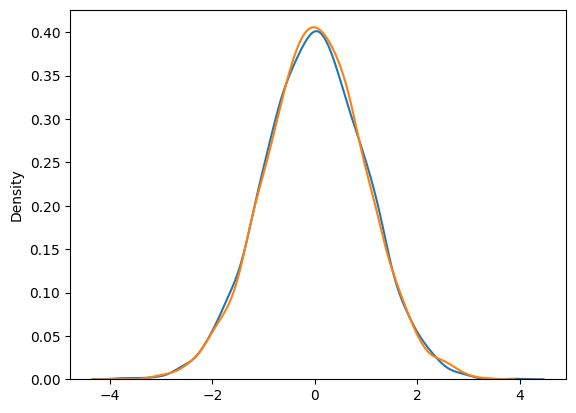

In [ ]:
oo=torch.randn(zt.shape[0],2)
sns.kdeplot(zt[:,0].detach().numpy())
sns.kdeplot(zt[:,1].detach().numpy())


In [ ]:


arr = torch.linspace(0, 1, steps=1000).cuda()


if Christ:

    tailsz=ndm.pred.tail_net(arr.unsqueeze(1).to(device))
else:

    tailsz=ndm.transform.tail(arr.unsqueeze(1).to(device))
    tailsz.shape

In [ ]:
tailsz[300]

tensor([ 0.0125,  0.0119,  0.0130,  0.0120, -0.0111, -0.0225,  0.3914,  0.4640],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
tailsz=tailsz.reshape(tailsz.shape[0],4,2)

lambda_x_p=tailsz[:,0,0].unsqueeze(1)
lambda_y_p=tailsz[:,0,1].unsqueeze(1)
lambda_x_n=tailsz[:,1,0].unsqueeze(1)
lambda_y_n=tailsz[:,1,1].unsqueeze(1)
data=torch.cat([lambda_x_p,lambda_y_p,lambda_x_n,lambda_y_n],1)
data.shape


torch.Size([1000, 4])

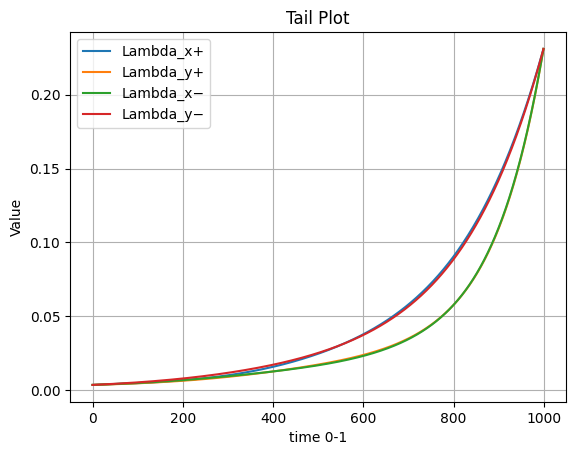

In [ ]:
import torch
import matplotlib.pyplot as plt

# Example tensor: batch_size x 4
batch_size = 1000
data=data.cpu().detach()
# Labels for each dimension
labels = ['Lambda_x+', 'Lambda_y+', 'Lambda_x−', 'Lambda_y−']

# Plot each of the 4 columns
for i in range(4):

    plt.plot(data[:, i], label=labels[i])

plt.xlabel('time 0-1')
plt.ylabel('Value')
plt.title('Tail Plot')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# bs = 2 ** 12

# zt = torch.randn(bs, 2).to(device)
# if approach=='A':
#     tailp=ndm.transform.tail(torch.ones(zt.shape[0],1).to(device))
#     zt=ndm.transform.noise2data(zt,tailp)
# else:
#     zt = torch.randn(bs, 2).to(device)



# def ode(z_in, t_in):
#     z_middle=z_in
#     if approach=='A':
#         tailp=transform.tail(t_in).to(device)
#         z_middle=transform.noise2data.inverse(z_in,tailp)

#     x_ = pred(z_middle, t_in)
#     _, dz, _ = transform.inverse(z_in, t_in, x_)
#     return dz


# _, (t_steps, path) = solve_ode(ode=ode, z=zt, ts=1, tf=0, n_steps=300)
# path=path.cpu()
# t_steps=t_steps.cpu()

# viz_2d_path(t_steps, path, n_lines=16, color="green")